<a href="https://colab.research.google.com/github/Sair-Shaikh/torch_practice/blob/main/CV_DataAug_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install --pre torch torchvision --extra-index-url https://download.pytorch.org/whl/nightly/cpu
!pip3 install matplotlib

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from torchvision import datasets


# Data Loading and Augmentation:

The purpose of this notebook is to highlight the differences on model accuracy between training on augmented and unaugmented datasets. Also, i'm trying to build intuition and practice using Pytorch, ConvNets, and DL in general.

In [3]:

# No transformations for unaugmented data
NO_AUG = transforms.Compose([ transforms.ToTensor()
                            ])

# Randomly applying Horizontal and Verticial Flips (images in the dataset are all oriented similarly)
# In the hope that the model will better detect the "shapes" of various objects. I played around with a bunch of transformations that looked interesting
# so not worried too much about which I picked.
AUG = transforms.Compose([  transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.ToTensor()
                          ])
RAND = transforms.Compose([ transforms.RandomRotation(0.2),
                            transforms.ToTensor()
                          ])


# Using CIFAR10 as it is small and standard. It contains around 60,000 32px x 32px images divided evenly between 10 categories.

# Loading two versions of the training dataset with and without transforms.
cifar_train_reg = torchvision.datasets.CIFAR10(root = 'data',
                                             train = True,
                                             download = True,
                                             transform = NO_AUG
                                             )


cifar_train_aug = torchvision.datasets.CIFAR10(root = 'data',
                                             train = True,
                                             download = True,
                                             transform = AUG
                                             )

# Augmenting the training set - only increasing the size by a factor of 2 with random transforms; could be more systematic but
# this will serve our exploratory purpose.
cifar_train_aug = torch.utils.data.ConcatDataset([cifar_train_aug, cifar_train_reg])

# Loading testing dataset with transformations, as a proxy for unseen real-world data
cifar_test = torchvision.datasets.CIFAR10(root = 'data',
                                            train = False,
                                            download=True,
                                            transform = RAND
                                          )

# Checking the size of the dataset and whether the augmentation worked
print(len(cifar_train_reg))
print(len(cifar_train_aug))
print(len(cifar_test))



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
50000
100000
10000


<ipython-input-4-445d80cd407e>:23: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.imshow(img.T)


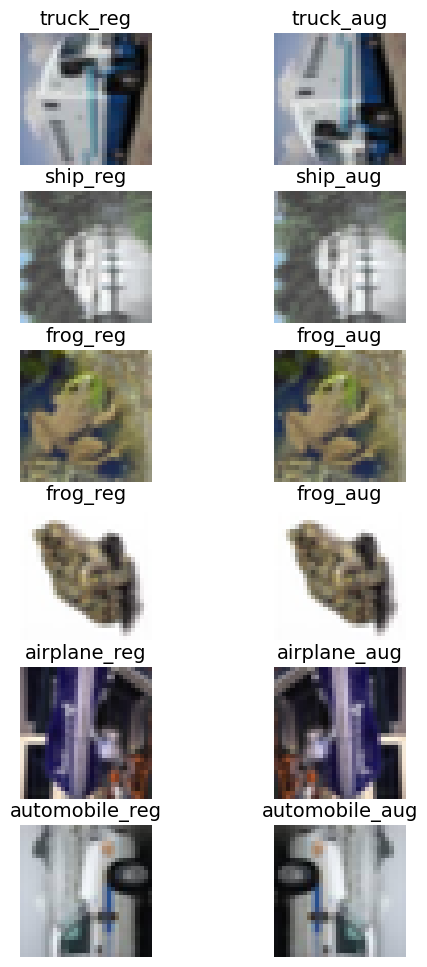

In [4]:
# Label map for the labels in CIFAR10
label_map = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

figsize = (6, 12)
figure = plt.figure(figsize=figsize)
rows = 6

# Looking at a random sample of augmented and unaugmented images.
for i in range(rows):
  idx = torch.randint(len(cifar_train_reg), size = (1,)).item() # Random index in the dataset
  for j in range(2): # Num Columns = 2
      # Based on column, selecting augmented or regular image
      if j==0:
        img, label = cifar_train_reg[idx]
        label = label_map[label] + "_reg" # Using the actual label to title the images
      else:
        img, label = cifar_train_aug[idx]
        label = label_map[label] + "_aug"

      figure.add_subplot(rows, 2, i*2+j+1)
      plt.axis("off")
      plt.title(label, fontsize=14)
      plt.imshow(img.T)
plt.show()


In [5]:
# Creating the dataloaders
batch_size = 256

train_reg_dl = DataLoader(cifar_train_reg, batch_size = batch_size, shuffle = True)
train_aug_dl = DataLoader(cifar_train_aug, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(cifar_test, batch_size = batch_size, shuffle = True)

# Building a ConvNet:

Creating a custom ConvNet structure. I tweaked the sizes of the Conv layers to see how the model performance would change - although I'm not aiming at maximum accuracy here (just experimenting with augmentation).

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        """Custom ConvNet with 3 Conv blocks, with a Conv layer and a MaxPool layer each, followed by a fully-connected head for classification. """
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding=1) # First Conv outputs 8 features
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)        # Doubles the features, as is good practice
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2) # To detect higher level features
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(16*128, 512) # After 3 layers of MaxPool, the 128 features have 16px
        self.lin2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout() # So that no particular features "take over"


    def forward(self, inp):
      # Model Architecture:

        # First Conv Block
        out = self.relu(self.conv1(inp))
        out = self.maxpool(out)

        # Second Conv Block
        out = self.relu(self.conv2(out))
        out = self.maxpool(out)

        # Third Conv Block
        out = self.relu(self.conv3(out))
        out = self.maxpool(out)

        # Classification Head
        out = self.flatten(out)
        out = self.relu(self.lin1(out))
        out = self.dropout(out)  # Common configuration for Dropout
        out = self.lin2(out)

        return out

Building two distinct models to train on the two datasets.

In [7]:
model_reg = ConvNet()
model_aug = ConvNet()

# Training:

We train both models using the standard loss function for multicategory classification and Adam Optimizer (because it is so good).

In [8]:
loss_func = nn.CrossEntropyLoss()
optimizer_reg = torch.optim.Adam(model_reg.parameters(), lr=1e-3)
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=1e-3)


In [9]:

def train(model, loss_func, optimizer, dataloader, epochs):

    # Initializing history variables
    loss_hist = []
    acc_hist = []

    for i in range(epochs):

        # Putting model in Training mode
        model.train()

        print("Epoch {:d} of {:d}:".format(i+1, epochs))

        # Accumulators for loss and accuracy over an epoch
        epoch_loss = 0
        epoch_acc = 0

        # Going through the data in batches
        for j, (imgs, labels) in enumerate(dataloader):

            # Finding prediction probabilities and the predicted classes
            probs = model(imgs)
            preds = torch.argmax(probs, 1)

            # Calculating loss and number of correct predictions and adding to epoch totals
            loss = loss_func(probs, labels)
            corr = torch.sum(preds == labels.data)
            epoch_loss += loss.item()
            epoch_acc += corr.item()

            # Printing every 100th batch to keep track of training progress (and troubleshoot) since cpu training is slow
            if ((j+1)% 100 == 0):
                print("\t For batch {:d}: Loss: {:f}, Accuracy: {:f}".format(j+1, loss.item()/batch_size, float(corr.item())/batch_size))

            # Gradient descent using Adam
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Calculating averae loss and accurary from epoch totals
        epoch_loss /= len(dataloader)
        epoch_acc  /= len(dataloader)

        # Printing epoch summary
        print("Epoch {:d}: Training Loss: {:f}, Accuracy: {:f} \n".format(i+1, epoch_loss, epoch_acc))

        # Adding epoch summary to history variables
        loss_hist.append(epoch_loss)
        acc_hist.append(epoch_acc)

    return(loss_hist, acc_hist)

# Training both models for 12 epochs
loss_hist_reg, acc_hist_reg = train(model_reg, loss_func=loss_func, optimizer=optimizer_reg, dataloader=train_reg_dl, epochs=12)
loss_hist_aug, acc_hist_aug = train(model_aug, loss_func=loss_func, optimizer=optimizer_aug, dataloader=train_aug_dl, epochs=12)

Epoch 1 of 12:
	 For batch 100: Loss: 0.030450, Accuracy: 0.234375
	 For batch 200: Loss: 0.029488, Accuracy: 0.296875
	 For batch 300: Loss: 0.026102, Accuracy: 0.421875
	 For batch 400: Loss: 0.023241, Accuracy: 0.328125
	 For batch 500: Loss: 0.021562, Accuracy: 0.562500
	 For batch 600: Loss: 0.021419, Accuracy: 0.453125
	 For batch 700: Loss: 0.019146, Accuracy: 0.578125
Epoch 1: Training Loss: 1.586459, Accuracy: 26.565217 

Epoch 2 of 12:
	 For batch 100: Loss: 0.020492, Accuracy: 0.562500
	 For batch 200: Loss: 0.016274, Accuracy: 0.656250
	 For batch 300: Loss: 0.017297, Accuracy: 0.609375
	 For batch 400: Loss: 0.020630, Accuracy: 0.625000
	 For batch 500: Loss: 0.020287, Accuracy: 0.562500
	 For batch 600: Loss: 0.017855, Accuracy: 0.515625
	 For batch 700: Loss: 0.015327, Accuracy: 0.625000
Epoch 2: Training Loss: 1.182372, Accuracy: 36.864450 

Epoch 3 of 12:
	 For batch 100: Loss: 0.015701, Accuracy: 0.640625
	 For batch 200: Loss: 0.018849, Accuracy: 0.625000
	 For batch

# Results:

We first compare the training loss and accuracy of our two models on their respective datasets.

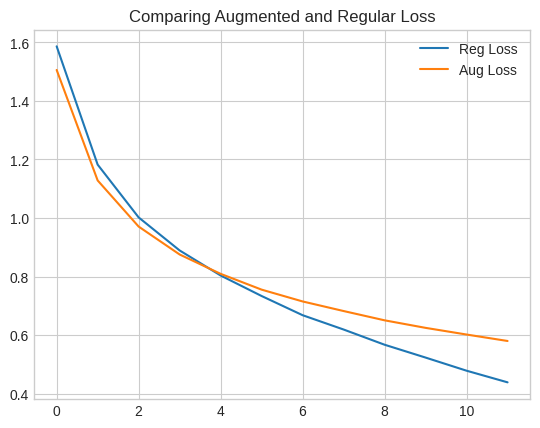

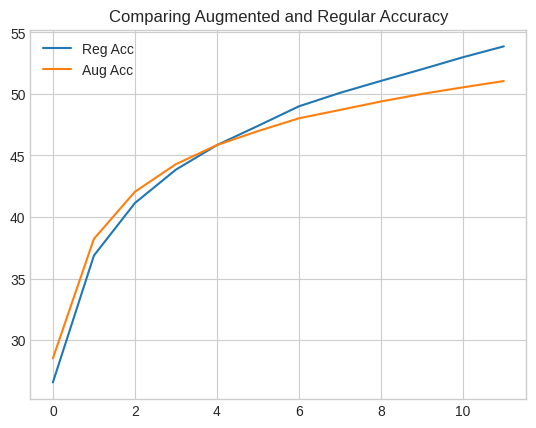

In [10]:
# Setting up the plots
plt.figsize = (5, 5)
plt.style.use("seaborn-v0_8-whitegrid")

# Plot of model training loss
plt.plot(loss_hist_reg, label="Reg Loss")
plt.plot(loss_hist_aug, label="Aug Loss")
plt.title("Comparing Augmented and Regular Loss")
plt.legend()
plt.show()

# Plot of model accuracy
plt.plot(acc_hist_reg, label="Reg Acc")
plt.plot(acc_hist_aug, label="Aug Acc")
plt.title("Comparing Augmented and Regular Accuracy")
plt.legend()
plt.show()

Now, we compare the models on the testing dataset (which has no transformations)

In [11]:
# Test Function to get Cross-Validation Scores
def test(model, dataloader):

    # Accumulating loss and count of correct predictions
    total_loss = 0
    total_corr = 0

    # Putting model in eval mode
    model.eval()

    # Since we are testing, we do not need to keep track of gradients
    with torch.no_grad():

        for imgs, labels in dataloader:

            # Calculating prediction probabilities and label predictions
            probs = model(imgs)
            preds = torch.argmax(probs, 1)

            # Accumulating loss and corrects
            total_loss = loss_func(probs, labels).item()
            total_corr += torch.sum(preds == labels).item()

        # Calculatung average loss and accuracy
        avg_loss = total_loss / len(dataloader)
        acc  = float(total_corr)/len(dataloader)

        # Printing testing summary
        print("Testing Loss: {:f}, Accuracy: {:f}".format(avg_loss, acc))

# Testing both models
test(model_reg, test_dl)
test(model_aug, test_dl)


Testing Loss: 0.006132, Accuracy: 48.178344
Testing Loss: 0.009669, Accuracy: 49.267516


ANALYSIS

I am curious to see how the regular model performs on the augmented dataset. Noting that it had access to half of that training set (the non-transformed half), I wanna see the drop in accuracy to qualitatively see how well the model succeeds/fails to generalize.

In [12]:
test(model_reg, train_aug_dl)

Testing Loss: 0.000536, Accuracy: 47.403071


ANALYSIS

Selecting a random image, I look at some features that the first Conv block of each model picked up. Qualitative visual differences in these can be interesting to note as a proxy for the effects of augmentation on training.

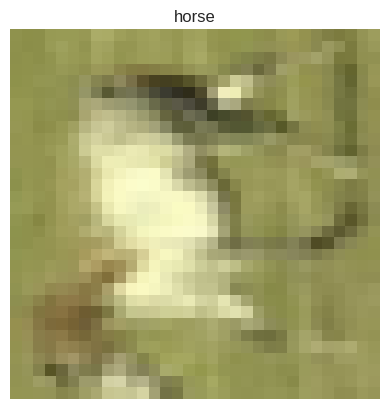

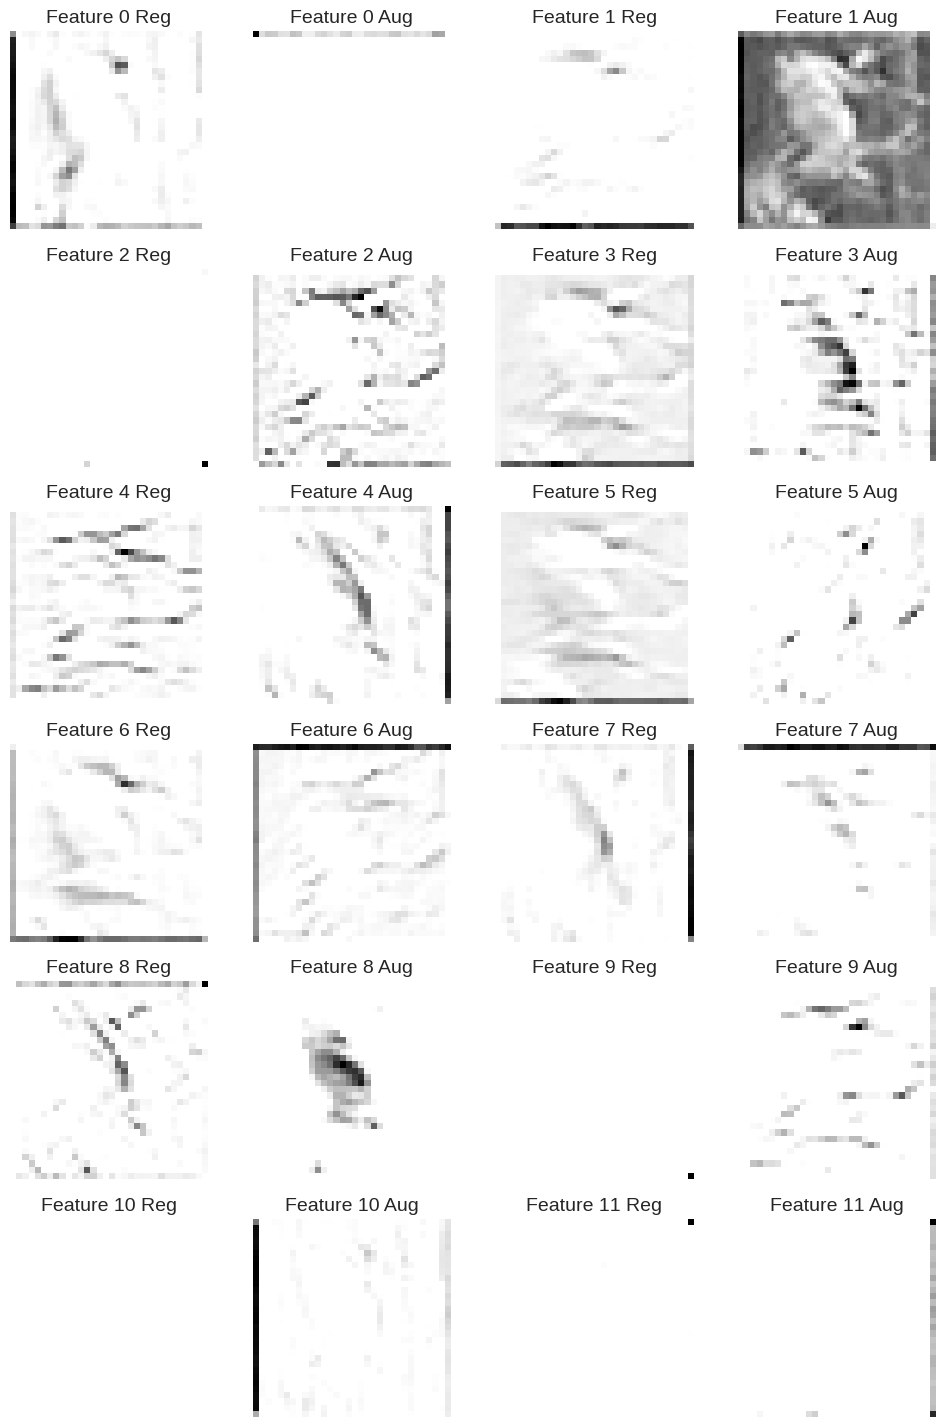

In [13]:
# Selecting a random number for each batch
idx = torch.randint(batch_size, size= (1,)).item()
imgs, labels = next(iter(test_dl))

# Unpacking the image data and the (text) label
img, label = imgs[idx], label_map[labels[idx].item()]

#Displaying the image
plt.title(label)
plt.imshow(img.T)
plt.axis("off")
plt.show()

# Calculating the features after the first Conv block
features_reg = model_reg.relu(model_reg.conv1(img))
features_aug = model_aug.relu(model_aug.conv1(img))

# Setting up the plot
figsize = (12, 18)
figure = plt.figure(figsize=figsize)

# Setting up the grid
row, cols = 8, 4
for i in range(rows):
  for j in range(cols):

      # Printing 2 features from each model per row (alternating)
      if j % 2 ==0:
        # Converting to numpy for matplotlib to use
        img = features_reg[2*i+j//2].T.detach().numpy()
        label = "Feature {:d} Reg".format(2*i+j//2)

      else:
        img = features_aug[2*i+int((j-1)//2)].T.detach().numpy()
        label = "Feature {:d} Aug".format(2*i+(j-1)//2)


      # Adding in the plots
      figure.add_subplot(rows, cols, i*cols+j+1)
      plt.axis("off")
      plt.title(label, fontsize=14)
      plt.imshow(img)
plt.show()


ANALYSIS

Saving the models:

In [14]:
torch.save(model_reg.state_dict(), "./cifar10reg.pth")
torch.save(model_aug.state_dict(), "./cifar10aug.pth")